In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style= 'darkgrid' )

#some built in functions
import itertools
from datetime import datetime, timedelta

import warnings
#to suppress warnings in Sarima model
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

#importing high level interactive plotting libraries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# importing time series stats model
import statsmodels.api as sm
from statsmodels.api import tsa 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#importing ARIMA family model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [2]:
df = pd.read_csv("Data/2010_present.csv")

In [3]:
df

,timestamp,total_amount
0,2010-01-01,148173.71
1,2010-01-02,165787.50
2,2010-01-03,162360.15
3,2010-01-04,164382.94
4,2010-01-05,171372.72
...,...,...
3706,2020-02-24,239531.25
3707,2020-02-25,260166.72
3708,2020-02-26,244752.97
3709,2020-02-27,224899.99


In [4]:
daily_data = df
tdi = pd.DatetimeIndex(daily_data.timestamp)
daily_data.set_index(tdi, inplace=True)
daily_data.drop(columns='timestamp', inplace=True)

In [5]:
daily_df = daily_data.copy()

In [6]:
def train_test_split(df, train_end, test_set):
    train_set = df[df.index <= train_end]
    test_set = df[df.index > train_end]
    return train_set, test_set

train_end = '2018-01-01'
test_end = '2020-02-28'

train_df, test_df = train_test_split(daily_data, train_end, test_end)

In [7]:
print(f'The Train data has time range :Shape {train_df.shape} | {train_df.index[0]} to {train_df.index[-1]}')
print(f'The Test data has time range :Shape {test_df.shape} | {test_df.index[0]} to {test_df.index[-1]}' )

The Train data has time range :Shape (2923, 1) | 2010-01-01 00:00:00 to 2018-01-01 00:00:00
The Test data has time range :Shape (788, 1) | 2018-01-02 00:00:00 to 2020-02-28 00:00:00


In [8]:
def plot_forecast(train_set, test_set, forecast_series:pd.Series):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_set.index, y=train_set, mode='lines', name='Train'))
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set, mode='lines', name='Test'))
    fig.add_trace(go.Scatter(x=forecast_series.index, y=forecast_series, mode='lines', name='Forecast'))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(yaxis_title='Revenue amount', xaxis_title='Date', title='Daily Sales amount and forecast')
    fig.show()

In [9]:
def plot_test_predictions(test_set, predictions) -> None:
    test_set = pd.Series(test_set, index=test_set.index)
    predictions = pd.Series(predictions, index=test_set.index)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set.values, mode='lines', name='Test'))
    fig.add_trace(go.Scatter(x=predictions.index, y=predictions.values, mode='lines', name='Predictions'))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(yaxis_title='Revenue amount for test and predicted values', xaxis_title='Date', title='Daily revenue amount')
    fig.show()

In [10]:
def mape(test_set, predicted) -> float:
    mape_result=round(np.mean(np.abs((test_set - predicted) / test_set)) * 100, 2)
    return mape_result

def rmse(test_set, predicted) -> float:
    rmse_result = round(np.sqrt(np.mean((test_set - predicted)**2)), 2)
    return rmse_result

In [11]:
def plot_acf_pacf(df, acf_lags: int, pacf_lags: int) -> None:
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,9), facecolor='w')

    plot_acf(df, lags=acf_lags, ax=ax1)
    plot_pacf(df, lags=pacf_lags, ax=ax2, method='ywm')

    ax1.set_title(f"Autocorrelation {df.name}", fontsize=15,pad=10)
    ax1.set_xlabel('Lags (days)', fontsize=12)
    ax1.set_ylabel('Sales amount', fontsize=12)

    ax2.set_title(f"Partial Autocorrelation {df.name}", fontsize=15,pad=10)
    ax2.set_xlabel('Lags (days)', fontsize=12)
    ax2.set_ylabel('Sales amount', fontsize=12)

    ax1.grid(linestyle=':', linewidth=1, color='grey')
    ax2.grid(linestyle=':', linewidth=1, color='grey')

    plt.show()


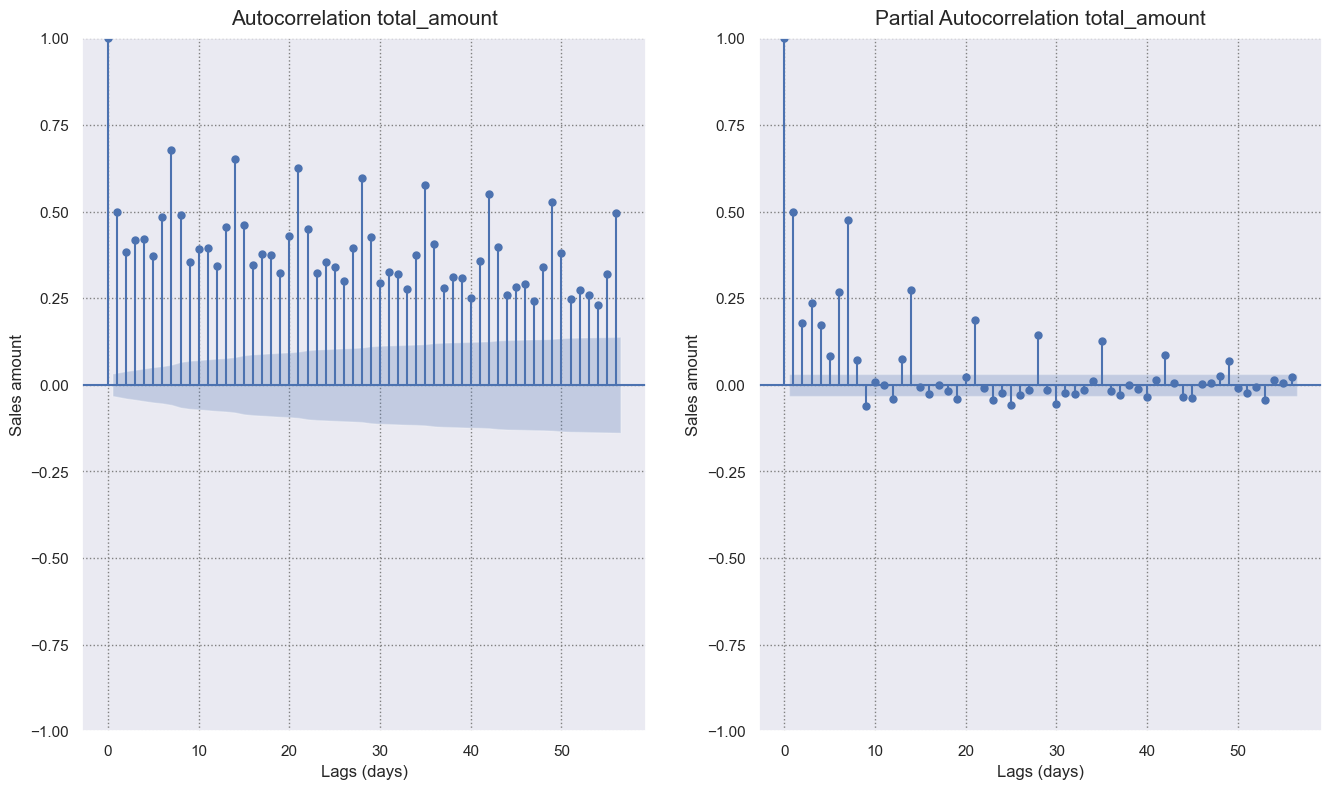

In [12]:
plot_acf_pacf(daily_df['total_amount'], acf_lags=56, pacf_lags=56)

In [13]:
daily_df['day_difference'] = daily_df['total_amount'].diff(1)

In [14]:
daily_df['double_difference'] = daily_df['day_difference'].diff(7)

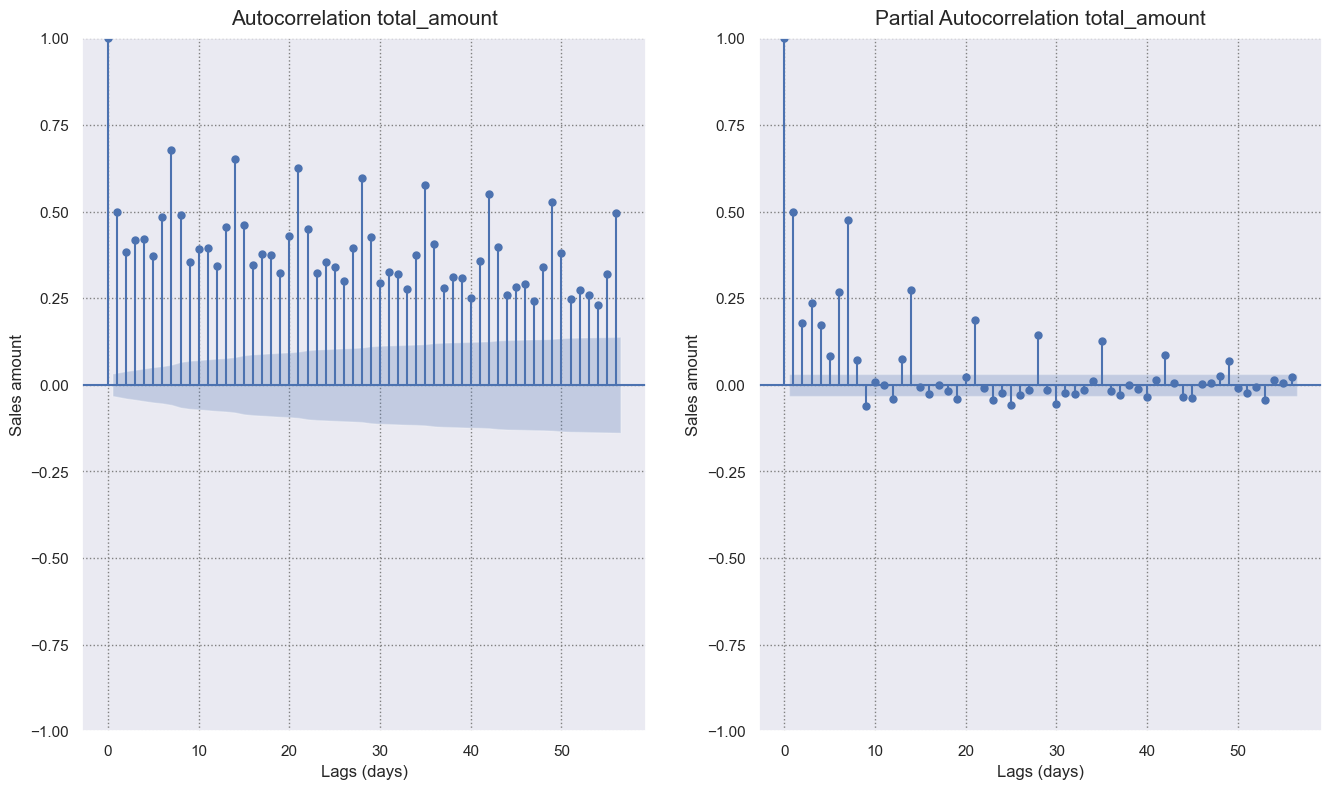

In [15]:
plot_acf_pacf(daily_df['total_amount'], acf_lags=56, pacf_lags=56)

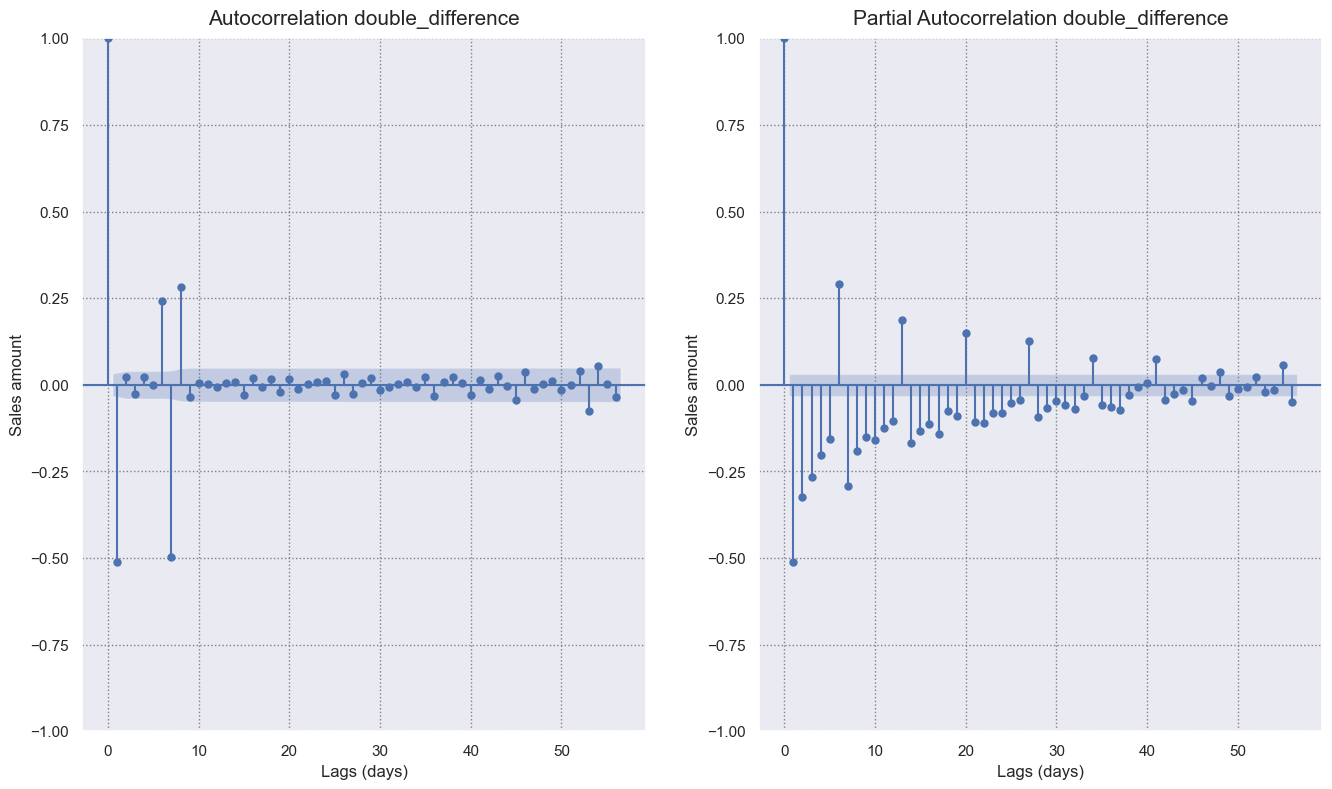

In [16]:
plot_acf_pacf(daily_df['double_difference'].dropna(), acf_lags=56,pacf_lags=56)

# ARIMA Baseline Model

In [17]:
# fit model
arima_model = ARIMA(train_df['total_amount'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
# summary of fit model
print(arima_model_fit.summary())

c:\Users\admin\anaconda3\envs\py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\anaconda3\envs\py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\admin\anaconda3\envs\py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           total_amount   No. Observations:                 2923
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -31253.287
Date:                Sun, 23 Jun 2024   AIC                          62512.574
Time:                        02:12:59   BIC                          62530.514
Sample:                    01-01-2010   HQIC                         62519.036
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0817      0.016      4.974      0.000       0.049       0.114
ma.L1         -0.9792      0.005   -178.127      0.000      -0.990      -0.968
sigma2      1.385e+08   2.44e-11   5.67e+18      0.0

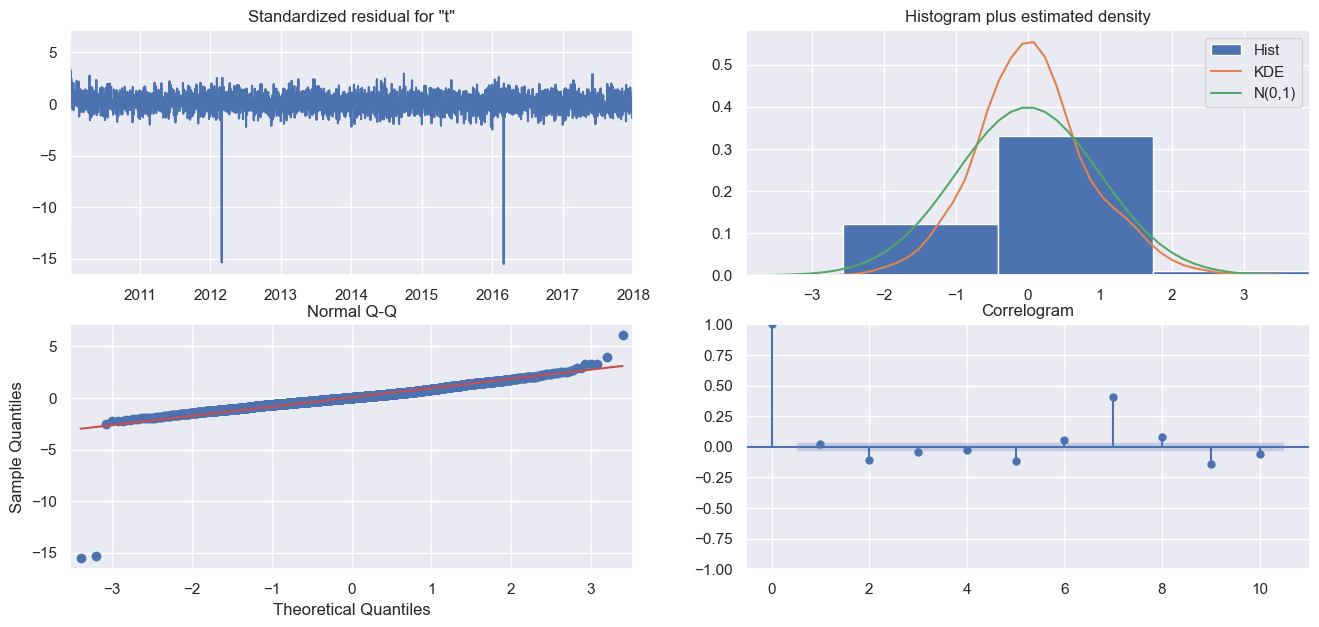

In [18]:
arima_model_fit.plot_diagnostics(figsize=(16,7))
plt.show()

In [19]:
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

arima_prediction = arima_model_fit.predict(start=pred_start_date, end=pred_end_date, dynamic=True)
arima_residual = test_df['total_amount'] - arima_prediction 

In [20]:
arima_rmse = rmse(test_df['total_amount'], arima_prediction)
arima_mape = mape(test_df['total_amount'], arima_prediction)

print(f'RMSE: {arima_rmse}')
print(f'MAPE: {arima_mape}')

RMSE: 14698.09
MAPE: 4.55


In [21]:
plot_test_predictions(test_df['total_amount'], arima_prediction)

In [22]:
# Sarima forecast
days = 365 * 2 + 182

arima_forecast = arima_model_fit.forecast(steps=days)
arima_forecast_series = pd.Series(arima_forecast, index=arima_forecast.index)


In [23]:
plot_forecast(train_df['total_amount'], test_df['total_amount'], arima_forecast_series)

# ARIME with Grid Search Model

In [24]:
p = range(0,8)
d = range(0,3)
q = range(0,3)


pdq = list(itertools.product(p,d,q))

# grid search for hyper parameters
def grid_search_sarima(train_set,test_set) -> None:
    warnings.simplefilter('ignore', category=UserWarning)

    # set initial variables
    pred_start_date = test_set.index[0]
    pred_end_date = test_set.index[-1]
    summary = pd.DataFrame(columns=['Model', 'MSE', 'AIC', 'BIC', 'RMSE', 'MAPE'])
    data = {}

    #grid search
    for order in pdq:
        model = ARIMA(train_set['total_amount'],
                        order=order)
        results = model.fit()
        predictions = results.predict(start=pred_start_date, end=pred_end_date) 
        data= { "Model":f'{order}',
                "MSE":results.mse,
                "AIC":results.aic, 
                "BIC":results.bic,
                "RMSE": rmse(test_set['total_amount'], predictions),
                "MAPE": mape(test_set['total_amount'], predictions) }
        summary=pd.concat([summary, pd.DataFrame(data, columns=summary.columns, index=[1])], ignore_index=True)
    
    return summary


In [25]:
result = grid_search_sarima(train_df, test_df)

# Sort the result by 'MAPE' in ascending order
sorted_result = result.sort_values('MAPE')

# Print the sorted result
print(sorted_result)

        Model           MSE           AIC           BIC        RMSE     MAPE
17  (1, 2, 2)  1.347648e+08  62682.326558  62706.245284    14434.79     4.51
10  (1, 0, 1)  1.070301e+08  62334.639896  62358.561359    14662.67     4.54
14  (1, 1, 2)  1.196067e+08  62428.091758  62452.011852    14699.59     4.55
5   (0, 1, 2)  1.202094e+08  62455.086107  62473.026177    14688.01     4.55
13  (1, 1, 1)  1.205535e+08  62512.573953  62530.514024    14698.09     4.55
..        ...           ...           ...           ...         ...      ...
42  (4, 2, 0)  2.268656e+08  64390.038819  64419.937226  1363298.50   574.20
33  (3, 2, 0)  2.368911e+08  64520.439575  64544.358301  1982015.18   834.95
24  (2, 2, 0)  2.844302e+08  65072.760601  65090.699645  3384370.95  1425.90
6   (0, 2, 0)  5.628552e+08  67077.352878  67083.332559  4696051.34  1978.84
15  (1, 2, 0)  3.683352e+08  65845.234400  65857.193763  6224221.70  2622.58

[72 rows x 6 columns]


In [26]:
sorted_result.head(10)

,Model,MSE,AIC,BIC,RMSE,MAPE
17,"(1, 2, 2)",1.347648e+08,62682.326558,62706.245284,14434.79,4.51
10,"(1, 0, 1)",1.070301e+08,62334.639896,62358.561359,14662.67,4.54
14,"(1, 1, 2)",1.196067e+08,62428.091758,62452.011852,14699.59,4.55
5,"(0, 1, 2)",1.202094e+08,62455.086107,62473.026177,14688.01,4.55
13,"(1, 1, 1)",1.205535e+08,62512.573953,62530.514024,14698.09,4.55
20,"(2, 0, 2)",1.056927e+08,62333.805497,62369.687692,14768.06,4.56
4,"(0, 1, 1)",1.214644e+08,62465.543626,62477.503673,14735.09,4.56
11,"(1, 0, 2)",1.063373e+08,62358.752749,62388.654578,14787.62,4.56
22,"(2, 1, 1)",1.183378e+08,62460.796520,62484.716614,14771.82,4.57
19,"(2, 0, 1)",1.064525e+08,62381.831865,62411.733694,14802.31,4.57


In [27]:
arima_model = ARIMA(train_df['total_amount'], order=(1, 2, 2))
arima_model_fit = arima_model.fit()
# summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           total_amount   No. Observations:                 2923
Model:                 ARIMA(1, 2, 2)   Log Likelihood              -31337.163
Date:                Sun, 23 Jun 2024   AIC                          62682.327
Time:                        02:14:32   BIC                          62706.245
Sample:                    01-01-2010   HQIC                         62690.942
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1493      0.011     13.714      0.000       0.128       0.171
ma.L1         -1.9818      0.005   -387.989      0.000      -1.992      -1.972
ma.L2          0.9819      0.005    192.296      0.0

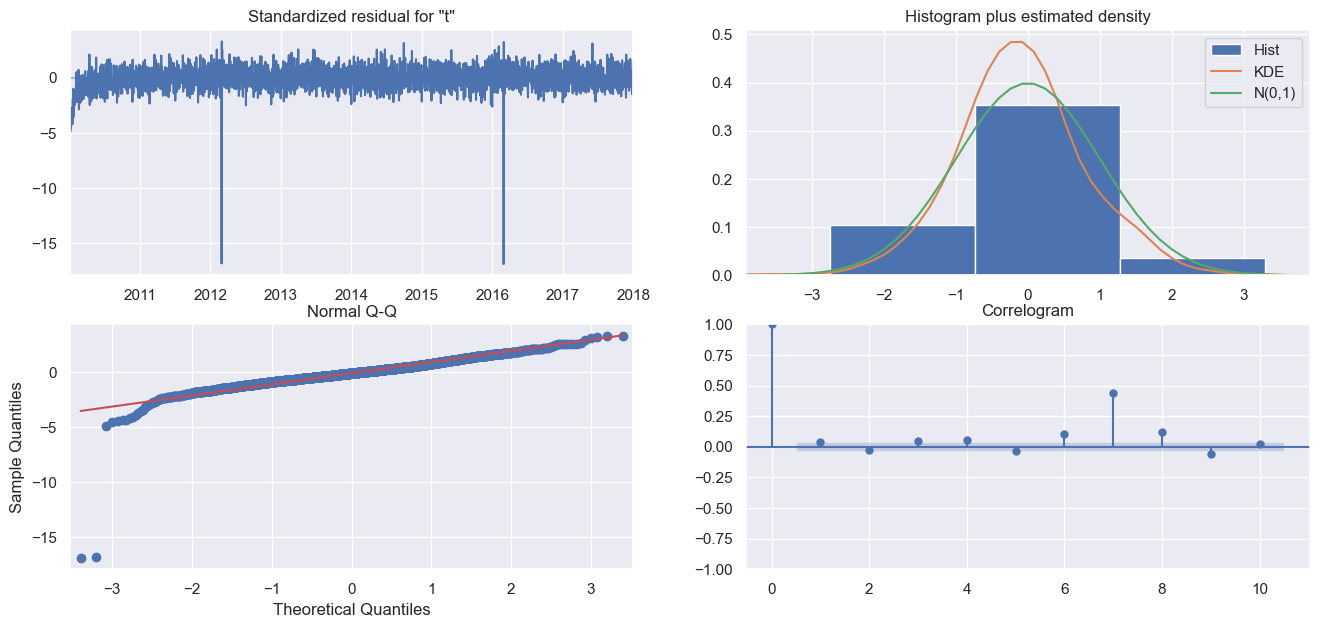

In [28]:
arima_model_fit.plot_diagnostics(figsize=(16,7))
plt.show()

In [29]:
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

arima_prediction = arima_model_fit.predict(start=pred_start_date, end=pred_end_date, dynamic=True)
arima_residual = test_df['total_amount'] - arima_prediction 

In [30]:
plot_test_predictions(test_df['total_amount'], arima_prediction)

In [31]:
days = 365 * 2 + 182

arima_forecast = arima_model_fit.forecast(steps=days)
arima_forecast_series = pd.Series(arima_forecast, index=arima_forecast.index)



In [32]:
plot_forecast(train_df['total_amount'], test_df['total_amount'], arima_forecast_series)

# SARIMA Baseline Model

In [33]:
# Set Hyper-parameters
p, d, q = 1,1,1
P, D, Q = 0,1,1
s=7

sarima_model = SARIMAX(train_df['total_amount'], order=(p,d,q), seasonal_order=(P,D,Q,s))
sarima_model_fit = sarima_model.fit(disp=0)
print(sarima_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      total_amount   No. Observations:                 2923
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -31051.879
Date:                           Sun, 23 Jun 2024   AIC                          62111.758
Time:                                   02:14:34   BIC                          62135.668
Sample:                               01-01-2010   HQIC                         62120.371
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0217      0.017     -1.299      0.194      -0.054       0.011
ma.L1         -0.7069      0.014    -50.621

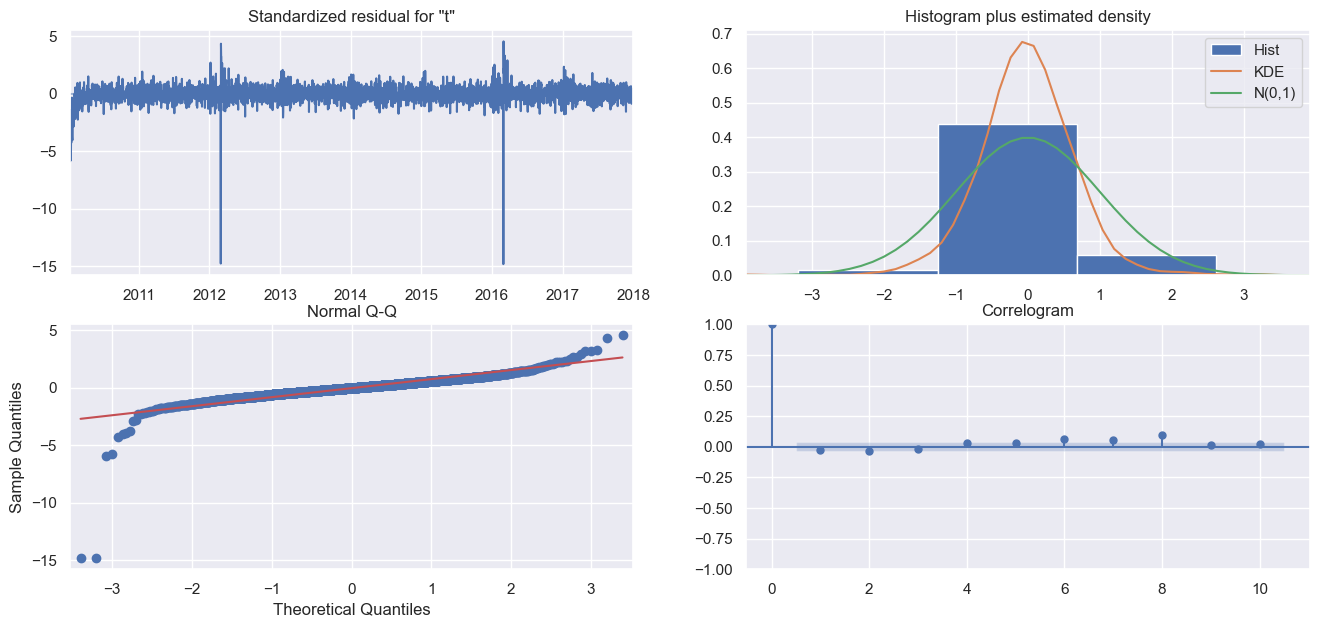

In [34]:
sarima_model_fit.plot_diagnostics(figsize=(16,7))
plt.show()

In [35]:
# define prediction period
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarima_prediction = sarima_model_fit.predict(start=pred_start_date, end=pred_end_date, dynamic=True)
sarima_residual = test_df['total_amount'] - sarima_prediction 

# evaluation SARIMA model
sarima_rmse = rmse(test_df['total_amount'], sarima_prediction)
sarima_mape = mape(test_df['total_amount'], sarima_prediction)

print(f'RMSE: {sarima_rmse}')
print(f'MAPE: {sarima_mape}')

RMSE: 71151.74
MAPE: 29.21


In [36]:
plot_test_predictions(test_df['total_amount'], sarima_prediction)

In [37]:
# Sarima forecast
days = 365 * 2 + 182

sarima_forecast = sarima_model_fit.forecast(steps=days)
sarima_forecast_series = pd.Series(sarima_forecast, index=sarima_forecast.index)

In [38]:
#plotting the forecast
plot_forecast(train_df['total_amount'], test_df['total_amount'], sarima_forecast_series)

# SARIMA with Grid Search

In [39]:
p = range(0,5)
d = range(0,2)
q = range(0,3)
s = 7

P = range(0,1)
D = range(0,2)
Q = range(0,3)

pdq = list(itertools.product(p,d,q))
seasonal_PDQ = list(itertools.product(P,D,Q))
seasonal_PDQS = [(x[0], x[1], x[2], s) for x in seasonal_PDQ]

# grid search for hyper parameters
def grid_search_sarima(train_set,test_set) -> None:
    warnings.simplefilter('ignore', category=UserWarning)

    # set initial variables
    pred_start_date = test_set.index[0]
    pred_end_date = test_set.index[-1]
    summary = pd.DataFrame(columns=['Model', 'MSE', 'AIC', 'BIC', 'RMSE', 'MAPE'])
    data = {}

    #grid search
    for order in pdq:
        for seasonal_order in seasonal_PDQS:
            model = SARIMAX(train_set['total_amount'], 
                            seasonal_order=seasonal_order,
                            order=order)
            results = model.fit(disp=0)
            predictions = results.predict(start=pred_start_date, end=pred_end_date) 

            data= { "Model":f'{order}x{seasonal_order}',
                    "MSE":results.mse,
                    "AIC":results.aic, 
                    "BIC":results.bic,
                    "RMSE": rmse(test_set['total_amount'], predictions),
                    "MAPE": mape(test_set['total_amount'], predictions) }

            summary=pd.concat([summary, pd.DataFrame(data, columns=summary.columns, index=[1])], ignore_index=True)
    
    return summary

# Call the function and store the result
result = grid_search_sarima(train_df, test_df)

# Sort the result by 'MAPE' in ascending order
sorted_result = result.sort_values('MAPE')

# Print the sorted result
sorted_result

,Model,MSE,AIC,BIC,RMSE,MAPE
116,"(3, 0, 1)x(0, 0, 2, 7)",9.632159e+07,61822.528573,61864.391134,14524.52,4.53
120,"(3, 0, 2)x(0, 0, 0, 7)",1.135688e+08,62364.575844,62400.458039,14676.57,4.54
78,"(2, 0, 1)x(0, 0, 0, 7)",1.135733e+08,62466.075859,62489.997322,14679.85,4.54
42,"(1, 0, 1)x(0, 0, 0, 7)",1.138410e+08,62336.668900,62354.609997,14662.41,4.54
43,"(1, 0, 1)x(0, 0, 1, 7)",1.021255e+08,61997.003696,62020.925159,14629.72,4.54
...,...,...,...,...,...,...
7,"(0, 0, 1)x(0, 0, 1, 7)",4.302316e+09,76893.456719,76911.397817,204199.98,99.52
1,"(0, 0, 0)x(0, 0, 1, 7)",1.054183e+10,77384.395851,77396.356582,204255.80,99.56
12,"(0, 0, 2)x(0, 0, 0, 7)",4.145894e+09,76878.433664,76896.374761,204754.81,99.89
6,"(0, 0, 1)x(0, 0, 0, 7)",1.059500e+10,77374.963503,77386.924235,204822.73,99.93


In [40]:
#set Hyper-parameter 
p, d, q = 3,0,1
P, D, Q = 0,0,2
s=7

sarima_model = SARIMAX(train_df['total_amount'], order=(p,d,q), seasonal_order=(P,D,Q,s))
sarimax_model_fit = sarima_model.fit(disp=0)
print(sarimax_model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                           total_amount   No. Observations:                 2923
Model:             SARIMAX(3, 0, 1)x(0, 0, [1, 2], 7)   Log Likelihood              -30904.264
Date:                                Sun, 23 Jun 2024   AIC                          61822.529
Time:                                        02:18:53   BIC                          61864.391
Sample:                                    01-01-2010   HQIC                         61837.606
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0552      0.002    538.232      0.000       1.051       1.059
ar.

In [41]:
#predicting 
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarimax_predictions = sarimax_model_fit.predict(start=pred_start_date, end=pred_end_date)

sarimax_root_mean_squared_error = rmse(test_df['total_amount'], sarimax_predictions)
sarimax_mape=mape(test_df['total_amount'], sarimax_predictions)

print(f'Root Mean Squared Error | RMSE: {sarimax_root_mean_squared_error}')
print(f'Mean Absolute Percentage Error | MAPE: {sarimax_mape}')

Root Mean Squared Error | RMSE: 14524.52
Mean Absolute Percentage Error | MAPE: 4.53


In [42]:
plot_test_predictions(test_df['total_amount'], sarimax_predictions)

In [43]:
# Forecast Window
days = 365 * 2 + 182
sarimax_forecast = sarimax_model_fit.forecast(days)
sarimax_forecast_series = pd.Series(sarimax_forecast, index=sarimax_forecast.index)

In [44]:
plot_forecast(train_df['total_amount'], test_df['total_amount'], sarimax_forecast_series)

# Auto SARIMA using pmdarima 

In [45]:
SARIMA_model = pm.auto_arima(train_df['total_amount'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=7, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [ ]:
SARIMA_model.params

<bound method ARIMA.params of ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(0, 1, 1, 7),
      suppress_warnings=True, with_intercept=False)>

In [ ]:
#set Hyper-parameter 
p, d, q = 2,0,1
P, D, Q = 0,1,1
s=7

sarima_model = SARIMAX(train_df['total_amount'], order=(p,d,q), seasonal_order=(P,D,Q,s))
sarimax_model_fit = sarima_model.fit(disp=0)
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      total_amount   No. Observations:                 2923
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -30666.920
Date:                           Sun, 23 Jun 2024   AIC                          61343.840
Time:                                   01:35:28   BIC                          61373.729
Sample:                               01-01-2010   HQIC                         61354.606
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9253      0.013     71.523      0.000       0.900       0.951
ar.L2          0.0531      0.012      4.440

In [ ]:
#predicting 
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarimax_predictions = sarimax_model_fit.predict(start=pred_start_date, end=pred_end_date)

sarimax_root_mean_squared_error = rmse(test_df['total_amount'], sarimax_predictions)
sarimax_mape=mape(test_df['total_amount'], sarimax_predictions)

print(f'Root Mean Squared Error | RMSE: {sarimax_root_mean_squared_error}')
print(f'Mean Absolute Percentage Error | MAPE: {sarimax_mape}')

In [ ]:
plot_test_predictions(test_df['total_amount'], sarimax_predictions)

In [ ]:
# Forecast Window
days = 365 * 2 + 182
sarimax_forecast = sarimax_model_fit.forecast(days)
sarimax_forecast_series = pd.Series(sarimax_forecast, index=sarimax_forecast.index)

In [ ]:
plot_forecast(train_df['total_amount'], test_df['total_amount'], sarimax_forecast_series)